# F455 Final Project

*By Tanya Rao and Vivek Rao*

For our project we decided to analyze 2019 data for the Chicago-based bike sharing system, Divvy. We used the existing data to generate a time series for net change in the number of bikes at Union Station every 30 minutes. We then used this time series to estimate models that would allow the company to predict how many bikes it needs to make available at various hours and days of the week.

In [1]:
import requests
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import date
import datetime

# Reading in the data

First, when reading the data, we source the open datasets on https://divvy-tripdata.s3.amazonaws.com/index.html.

We decided to work with 2019 data to avoid the changes brought on by lockdown restrictions starting early March 2020.

We notice that the data is broken into four quarters and the URL to each zip folder follows a syntax. Rather than downloading and separately loading in the CSV files, we can easily load each CSV to a Pandas DataFrame, all within Jupyter.

The following code cell takes close to 10 minutes to run.

In [2]:
# load base URL to easily populate syntax
base_url='https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q'

# set up empty DataFrame
df=pd.DataFrame()

# loop through each of the zip files
# there are four quarters labelled Q1 through Q4, so this is a fairly simple loop
for i in range(1,5,1):
    
    # append quarter number to syntax
    base_url='https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q' + str(i) + '.zip'
    res=requests.get(base_url)
    temp_files=ZipFile(BytesIO(res.content))
    
    # read the first file in the ZIP folder
    temp_df=pd.read_csv(temp_files.open(temp_files.namelist()[0]), thousands=',')
    
    # add the contents of this quarter's data to the main DataFrame
    df=df.append(temp_df,ignore_index=True)

# output DataFrame so we can see what it looks like
df

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,01 - Rental Details Local End Time,01 - Rental Details Bike ID,01 - Rental Details Duration In Seconds Uncapped,03 - Rental Start Station ID,03 - Rental Start Station Name,02 - Rental End Station ID,02 - Rental End Station Name,User Type,Member Gender,05 - Member Details Member Birthday Year
0,21742443.0,2019-01-01 00:04:37,2019-01-01 00:11:07,2167.0,390.0,199.0,Wabash Ave & Grand Ave,84.0,Milwaukee Ave & Grand Ave,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21742444.0,2019-01-01 00:08:13,2019-01-01 00:15:34,4386.0,441.0,44.0,State St & Randolph St,624.0,Dearborn St & Van Buren St (*),Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21742445.0,2019-01-01 00:13:23,2019-01-01 00:27:12,1524.0,829.0,15.0,Racine Ave & 18th St,644.0,Western Ave & Fillmore St (*),Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21742446.0,2019-01-01 00:13:45,2019-01-01 00:43:28,252.0,1783.0,123.0,California Ave & Milwaukee Ave,176.0,Clark St & Elm St,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21742447.0,2019-01-01 00:14:52,2019-01-01 00:20:56,1170.0,364.0,173.0,Mies van der Rohe Way & Chicago Ave,35.0,Streeter Dr & Grand Ave,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817999,25962900.0,2019-12-31 23:56:13,2020-01-01 00:15:45,2196.0,1172.0,112.0,Green St & Randolph St,225.0,Halsted St & Dickens Ave,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818000,25962901.0,2019-12-31 23:56:34,2020-01-01 00:22:08,4877.0,1533.0,90.0,Millennium Park,90.0,Millennium Park,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818001,25962902.0,2019-12-31 23:57:05,2020-01-01 00:05:46,863.0,520.0,623.0,Michigan Ave & 8th St,52.0,Michigan Ave & Lake St,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818002,25962903.0,2019-12-31 23:57:11,2020-01-01 00:05:45,2637.0,514.0,623.0,Michigan Ave & 8th St,52.0,Michigan Ave & Lake St,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We immediately notice there are close to four million rows. To streamline our project, we won't be needing all of them. But before we get to work with a clean DataFrame, we have to clean our data.

# Cleaning the data

In [3]:
df.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       '01 - Rental Details Rental ID', '01 - Rental Details Local Start Time',
       '01 - Rental Details Local End Time', '01 - Rental Details Bike ID',
       '01 - Rental Details Duration In Seconds Uncapped',
       '03 - Rental Start Station ID', '03 - Rental Start Station Name',
       '02 - Rental End Station ID', '02 - Rental End Station Name',
       'User Type', 'Member Gender',
       '05 - Member Details Member Birthday Year'],
      dtype='object')

From the list of columns above, we see that some columns have been repeated but with different names. After examining each DataFrame individually, we noticed that column headers for Q2 were different than standard column headers. To rectify this, we shift contents of those columns to the original columns. To start, we first find which rows are affected.

We can do this by looking at where df['start_time'] is empty — it'll be empty because values occupy the df['01 - Rental Details Local Start Time'] column instead.

In [4]:
np.where(df['01 - Rental Details Local Start Time'].notna())

(array([ 365069,  365070,  365071, ..., 1473229, 1473230, 1473231],
       dtype=int64),)

To get a better view of what this slice of the DataFrame looks like:

In [5]:
df.iloc[365069:1473231, 0:12]

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
365069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1473226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To fix this, the values in the second (vertical) half of the DataFrame must instead be moved to the first (vertical) half of the DataFrame, for this particular slice.

In [6]:
df.iloc[365069:1473231, 0:12] = df.iloc[365069:1473231, 12:24]

Now we can delete the other set of columns.

In [7]:
df=df.drop(['01 - Rental Details Rental ID', '01 - Rental Details Local Start Time',
       '01 - Rental Details Local End Time', '01 - Rental Details Bike ID',
       '01 - Rental Details Duration In Seconds Uncapped',
       '03 - Rental Start Station ID', '03 - Rental Start Station Name',
       '02 - Rental End Station ID', '02 - Rental End Station Name',
       'User Type', 'Member Gender',
       '05 - Member Details Member Birthday Year'], axis=1)

Our next step in data pre-processing will be to read the datetime values as datetimes, not string. To do this, we use the ```to_datetime``` function offers.

On another note, when originally loading the data, we saw that numbers were read in as string, however, we fixed this by adding the ```thousands=','``` argument in the ```read_csv``` function.

In [8]:
df.start_time = pd.to_datetime(df.start_time, format="%Y-%m-%d %H:%M:%S")
df.end_time = pd.to_datetime(df.end_time, format="%Y-%m-%d %H:%M:%S")

Now we run descriptive statistics on all columns to filter out funky values:

In [9]:
df.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear
count,3.818003e+06,3.818003e+06,3.818003e+06,3.818003e+06,3.818003e+06,3.279252e+06
mean,2.391563e+07,3.380252e+03,1.450203e+03,2.016659e+02,2.026363e+02,1.984074e+03
std,1.212667e+06,1.902511e+03,2.985415e+04,1.560798e+02,1.562388e+02,1.086898e+01
min,2.174244e+07,1.000000e+00,6.100000e+01,1.000000e+00,1.000000e+00,1.759000e+03
25%,2.287379e+07,1.727000e+03,4.110000e+02,7.700000e+01,7.700000e+01,1.979000e+03
50%,2.396232e+07,3.451000e+03,7.090000e+02,1.740000e+02,1.740000e+02,1.987000e+03
75%,2.496370e+07,5.046000e+03,1.283000e+03,2.890000e+02,2.910000e+02,1.992000e+03
max,2.596290e+07,6.946000e+03,1.062840e+07,6.730000e+02,6.730000e+02,2.014000e+03


We know that df['tripduration'] is measured in seconds, however, the longest ride was 123 days. This is clearly an error, and we would want to remove it. On that note, we assume that any ride longer than an hour may be error, or that someone didn't dock their bike right. To account for this:

In [10]:
df=df[df.tripduration <= 60*60]

# Beginning our analysis

Now, we're left with a little more than three million rows. That's still a lot of data to analyze. To make the task easier, and to find better patterns, we want to specify traffic in and out of just one station.

We want to analyze traffic data in and out of the Divvy station in front of Union Station, on Canal and Adams. To get a better idea of how much traffic this particular station generates, we count how many bikes left this station in 2019.

In [11]:
df.from_station_name.value_counts()

Streeter Dr & Grand Ave                 57987
Canal St & Adams St                     53957
Clinton St & Madison St                 49446
Clinton St & Washington Blvd            47876
Lake Shore Dr & Monroe St               42817
                                        ...  
Racine Ave & 61st St                        5
South Chicago Ave & Elliot Ave              4
DIVVY CASSETTE REPAIR MOBILE STATION        3
Special Events                              1
LBS - BBB La Magie                          1
Name: from_station_name, Length: 640, dtype: int64

And here's how many bikes were docked back into this station:

In [12]:
df.to_station_name.value_counts()

Streeter Dr & Grand Ave                 68627
Clinton St & Washington Blvd            50479
Canal St & Adams St                     49868
Clinton St & Madison St                 46954
Lake Shore Dr & North Blvd              39094
                                        ...  
South Chicago Ave & Elliot Ave              6
DIVVY CASSETTE REPAIR MOBILE STATION        3
TS ~ DIVVY PARTS TESTING                    2
Special Events                              1
LBS - BBB La Magie                          1
Name: to_station_name, Length: 641, dtype: int64

To do this, we filter the dataset to only the rides that start or end at Canal & Adams. For starters, we'll find the Station ID for this particular station (so we won't have to use strings to index).

In [13]:
df[df.from_station_name=="Canal St & Adams St"]['from_station_id']

288        192.0
542        192.0
818        192.0
1289       192.0
1370       192.0
           ...  
3817729    192.0
3817910    192.0
3817911    192.0
3817912    192.0
3817913    192.0
Name: from_station_id, Length: 53957, dtype: float64

In [14]:
df=df[(df.from_station_id == 192) | (df.to_station_id == 192)]

Now, we create a new column called 'net_change'. This will measure the change in bikes at the Union Station change. We want to assign a +1 if a bike docks **at** the station, and a -1 if a bike is docked **from** the station.

In [15]:
# assign a -1 to rides when bikes are FROM the station — the station is now one bike fewer
df.loc[df['from_station_id'] == 192, 'net_change'] = -1

# assign a +1 to rides when bikes are TO the station — the station now has one bike more
df.loc[df['to_station_id'] == 192, 'net_change'] = 1

Now, we only want time series data and net change in the number of bikes. We further filter our DataFrame to include those two columns.

In [16]:
filtered_df=df[['start_time', 'net_change']]

In [17]:
filtered_df=filtered_df.set_index('start_time')

Resample to get data for 30-minute intervals.

In [18]:
filtered_df=filtered_df.resample('30min').sum()

#### A look into the data

Here, we take an aside to examine what the data looks like for one day — let's say Feb. 18, 2019.

In [19]:
feb18=filtered_df['2019-02-18']

C:\Users\Vivek Rao\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


C:\Users\Vivek Rao\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Vivek Rao\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Vivek Rao\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Net bikes docked')

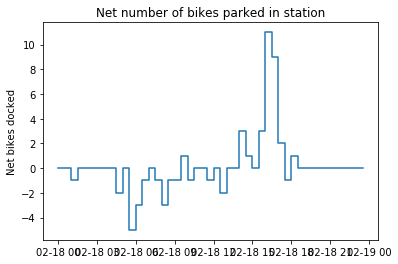

In [20]:
plt.step(x=feb18.index, y=feb18.net_change)
plt.title('Net number of bikes parked in station')
plt.ylabel('Net bikes docked')

From the above plot, we see that there's an influx of bikes at the station between 4:30 and 5:00 p.m. Feb. 18 was a Monday, so this must've coincided with employees in the West Loop entering Union Station to catch their train back to the suburbs.

# Setting up test dataset

To test the efficacy of our models, we input data from Q2 of 2018 to test our model(s) on. To do this, we touch on the principles of test-train datasets and we apply our function to Q2 of 2018. Then we measure our residuals and see how close our model is.

We specifically chose Q2 since the weather in April-June is generally conducive to riding a bike outdoors. This eliminates prediction error due to weather effects.

In [21]:
# our first step would be to load the test dataset
# load base URL to easily populate syntax
base_url='https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2018_Q2.zip'

# set up empty DataFrame
# test=pd.DataFrame()

# loop through each of the zip files
# there are four quarters labelled Q1 through Q4, so this is a fairly simple loop
for i in range(1,5,1):
    
    # append quarter number to syntax
    res=requests.get(base_url)
    temp_files=ZipFile(BytesIO(res.content))
    
    # read the first file in the ZIP folder
    test=pd.read_csv(temp_files.open(temp_files.namelist()[0]), thousands=',')
    
# parsing dates as dates
test.start_time = pd.to_datetime(test.start_time, format="%Y-%m-%d %H:%M:%S")
test.end_time = pd.to_datetime(test.end_time, format="%Y-%m-%d %H:%M:%S")

# filtering to only Union Station trips
test=test[(test.from_station_id == 192) | (test.to_station_id == 192)]

# assign a -1 to rides when bikes are FROM the station — the station is now one bike fewer
test.loc[test['from_station_id'] == 192, 'net_change'] = -1

# assign a +1 to rides when bikes are TO the station — the station now has one bike more
test.loc[test['to_station_id'] == 192, 'net_change'] = 1

test=test[['start_time', 'net_change']]
test=test.set_index('start_time')
test=test.resample('30min').sum()
test

,net_change
start_time,
2018-04-01 06:30:00,1.0
2018-04-01 07:00:00,0.0
2018-04-01 07:30:00,-1.0
2018-04-01 08:00:00,0.0
2018-04-01 08:30:00,0.0
...,...
2018-06-30 21:30:00,1.0
2018-06-30 22:00:00,1.0
2018-06-30 22:30:00,2.0


We then convert this dataset to a series to allow for datetime calculations.

In [22]:
test_copy=test.loc[:,'net_change']
test_copy

start_time
2018-04-01 06:30:00    1.0
2018-04-01 07:00:00    0.0
2018-04-01 07:30:00   -1.0
2018-04-01 08:00:00    0.0
2018-04-01 08:30:00    0.0
                      ... 
2018-06-30 21:30:00    1.0
2018-06-30 22:00:00    1.0
2018-06-30 22:30:00    2.0
2018-06-30 23:00:00   -3.0
2018-06-30 23:30:00    3.0
Freq: 30T, Name: net_change, Length: 4355, dtype: float64

# Really beginning our analysis

In [23]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import stattools as st
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

We plotted our time series data to check for seasonality. The plot below shows all of our 2019 30-minute interval data – the regular up and down movement of the graph clearly indicates that there is some seasonality present.

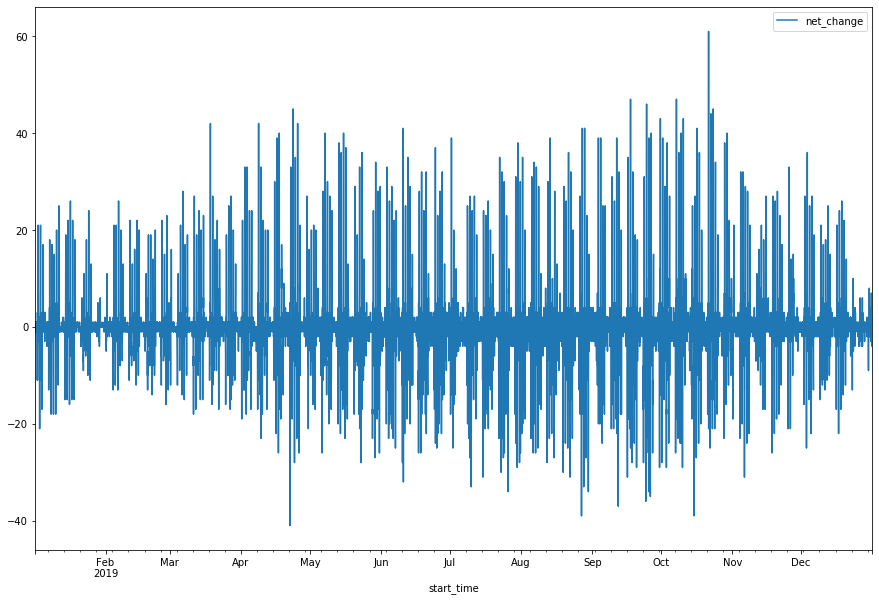

In [24]:
filtered_df.plot(figsize=(15,10))

To get a clearer picture of the trends, we plotted just the first two weeks of data. For reference, January 2nd, 2019 was a Wednesday. The plot below shows much higher net changes during weekdays compared to weekends, with a high negative net changes on weekday mornings and high positive net changes in the evenings. These changes correspond to employees using the bikes to get to work in the mornings and to get back to Union Station to catch their trains home in the evenings. 

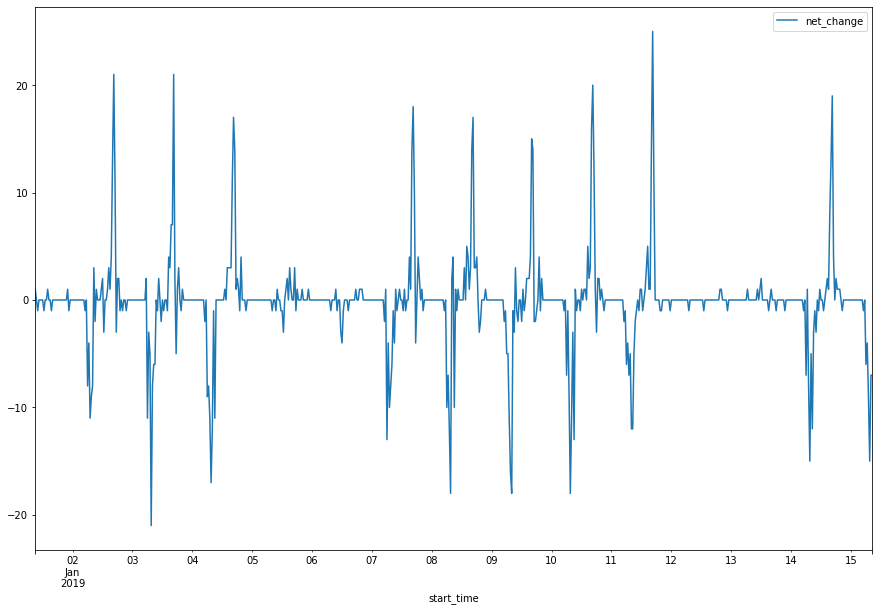

In [25]:
filtered_df[0:672].plot(figsize=(15,10))

In order to use our time-series data to predict bike availability requirements in future, we first decided to fit an Autoregressive model. We used the "ar_select_order" function to determine the number of lags to include in our model.

In [26]:
sel1 = ar_select_order(filtered_df,48, old_names= False)
sel1.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [27]:
sel1.aic

{(1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48): 2.695623643993519,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47): 2.7786192597371806,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46): 2.871457258112859,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  2

In [28]:
sel1.bic

{(1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48): 2.7174305582660576,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47): 2.7999811349429327,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46): 2.8923740942518243,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
 

The above lag, AIC, and BIC results indicate we should include all 48 lags into our model. The results are as follows:

### Model 1

Model 1 is an AR(48) model.

In [29]:
res1 = sel1.model.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:             net_change   No. Observations:                17501
Model:                    AutoReg(48)   Log Likelihood              -48239.094
Method:               Conditional MLE   S.D. of innovations              3.838
Date:                Fri, 30 Apr 2021   AIC                              2.696
Time:                        16:49:34   BIC                              2.718
Sample:                    01-02-2019   HQIC                             2.703
                         - 12-31-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1502      0.031     -4.880      0.000      -0.210      -0.090
net_change.L1      0.4064      0.007     55.966      0.000       0.392       0.421
net_change.L2     -0.0831      0.008

### Testing:

Now that we have a model, we want to predict how accurate it is with our test dataset.

The following code cell creates a function that, for every row in the test dataset, picks out values from lags 1, 15, 16, 48 and 336. We create a new function for each model, since not every model uses the same lag terms.

In [30]:
def p1_test_lags(i):
    p1_lags = []
    for a in range(1,49):
        next_lag = test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=a/2)]
        p1_lags.append(next_lag)
    return np.array(p1_lags)

In [31]:
test['prediction1'] = np.zeros(len(test))

# picking out the constant term from the model
constant=res1.params[0]

# picking out the lag coefficients from the model
p1_lag_coeff=res1.params[1:49]

# we say 48 in the following loop because the furthest
# lag term is 48, so prediction values will be NaN until
# that lag term.

for i in range(48,4355):
   
    # removing constant term since Model 6 doesn't have one
    test['prediction1'][i]= constant + p1_test_lags(i) @ p1_lag_coeff

test

,net_change,prediction1
start_time,,
2018-04-01 06:30:00,1.0,0.000000
2018-04-01 07:00:00,0.0,0.000000
2018-04-01 07:30:00,-1.0,0.000000
2018-04-01 08:00:00,0.0,0.000000
2018-04-01 08:30:00,0.0,0.000000
...,...,...
2018-06-30 21:30:00,1.0,0.989324
2018-06-30 22:00:00,1.0,0.109208
2018-06-30 22:30:00,2.0,-0.231789


In [32]:
dummy1 = res1.params[0:48]

const            -0.150183
net_change.L1     0.406373
net_change.L2    -0.083111
net_change.L3    -0.044215
net_change.L4     0.025272
net_change.L5     0.016593
net_change.L6    -0.018852
net_change.L7     0.008481
net_change.L8     0.031552
net_change.L9    -0.020726
net_change.L10    0.022011
net_change.L11   -0.017411
net_change.L12   -0.016644
net_change.L13   -0.012407
net_change.L14   -0.029922
net_change.L15   -0.048352
net_change.L16   -0.064644
net_change.L17   -0.067192
net_change.L18   -0.044428
net_change.L19    0.011376
net_change.L20   -0.001458
net_change.L21   -0.000495
net_change.L22    0.022281
net_change.L23    0.030838
net_change.L24   -0.038080
net_change.L25    0.041417
net_change.L26    0.005419
net_change.L27   -0.017690
net_change.L28    0.009342
net_change.L29   -0.030307
net_change.L30   -0.052768
net_change.L31   -0.037010
net_change.L32   -0.036479
net_change.L33   -0.020450
net_change.L34   -0.023115
net_change.L35   -0.007709
net_change.L36   -0.009084
n

In [33]:
test['error1'] = np.zeros(len(test))
test['error1'] = test['prediction1'] - test['net_change']
test[48:]

,net_change,prediction1,error1
start_time,,,
2018-04-02 06:30:00,-4.0,-1.934805,2.065195
2018-04-02 07:00:00,-11.0,-1.044493,9.955507
2018-04-02 07:30:00,-20.0,-4.240596,15.759404
2018-04-02 08:00:00,-23.0,-7.104188,15.895812
2018-04-02 08:30:00,-12.0,-7.438476,4.561524
...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676
2018-06-30 22:00:00,1.0,0.109208,-0.890792
2018-06-30 22:30:00,2.0,-0.231789,-2.231789


From statistics classes we've taken around IU, we learned that a good model minimizes residuals, or the the sum of all residuals should be as close to zero as possible.

In [34]:
test[48:]['error1'].sum()

-352.28901809049046

An absolute value of 352 seems a little high. To remedy this, we decided to try out another model.

Our time-series data also has some seasonality, so we decided to fit an AR model that included dummy variables to account for this.

### Model 2

Model 2 is an AR(48) with 48 dummy variables for time intervals.

In [35]:
sel2 = ar_select_order(filtered_df, maxlag = 48, trend="n", period = 48, seasonal = True, old_names= False)
sel2.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [36]:
res2 = sel2.model.fit()
print(res2.summary())

                            AutoReg Model Results                             
Dep. Variable:             net_change   No. Observations:                17501
Model:              Seas. AutoReg(48)   Log Likelihood              -46916.633
Method:               Conditional MLE   S.D. of innovations              3.558
Date:                Fri, 30 Apr 2021   AIC                              2.550
Time:                        16:50:10   BIC                              2.593
Sample:                    01-02-2019   HQIC                             2.564
                         - 12-31-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
s(1,48)           -0.4847      0.231     -2.094      0.036      -0.938      -0.031
s(2,48)            1.3057      0.231      5.645      0.000       0.852       1.759
s(3,48)           -0.2450      0.231

### Testing out Model 2

Our next step is to save the lag coefficients from Model 2.

In [37]:
p2_lag_coeff = np.array(res2.params[48:])

Creating a dummy variable coefficients array for dummy coefficients of Model 2.

In [38]:
dummy2=res2.params[0:48]

In [39]:
test['prediction2'] = np.zeros(len(test))

# we say 48 in the following loop because the furthest
# lag term is 48, so prediction values will be NaN until
# that lag term.

for i in range(48,4355):
    
    # the following lines of code create an array of zeros and assigns
    # the number 1 to one index in the array. The 
    # values in the array each correspond to a time.
    # For example, the first value is 09:00, because the dataset
    # starts at 9AM.
    
    # If the time is 10AM, the third value in the array would be a 1.
    
    if int(test.index[i].minute) == 30:
        p2_dummy_index=(int(test.index[i].hour)-9)*2 + 1
    else:
        p2_dummy_index=(int(test.index[i].hour)-9)*2

    p2_dummy_hours = np.zeros(48)
    p2_dummy_hours[int(p2_dummy_index)]=1
    test['prediction2'][i]= p1_test_lags(i) @ p2_lag_coeff + dummy2 @ p2_dummy_hours 

test[48:]

,net_change,prediction1,error1,prediction2
start_time,,,,
2018-04-02 06:30:00,-4.0,-1.934805,2.065195,-3.621585
2018-04-02 07:00:00,-11.0,-1.044493,9.955507,-2.732035
2018-04-02 07:30:00,-20.0,-4.240596,15.759404,-8.587869
2018-04-02 08:00:00,-23.0,-7.104188,15.895812,-8.993520
2018-04-02 08:30:00,-12.0,-7.438476,4.561524,-9.468034
...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137


In [40]:
test['error2'] = np.zeros(len(test))
test['error2'] = test['prediction2'] - test['net_change']
test[48:]

,net_change,prediction1,error1,prediction2,error2
start_time,,,,,
2018-04-02 06:30:00,-4.0,-1.934805,2.065195,-3.621585,0.378415
2018-04-02 07:00:00,-11.0,-1.044493,9.955507,-2.732035,8.267965
2018-04-02 07:30:00,-20.0,-4.240596,15.759404,-8.587869,11.412131
2018-04-02 08:00:00,-23.0,-7.104188,15.895812,-8.993520,14.006480
2018-04-02 08:30:00,-12.0,-7.438476,4.561524,-9.468034,2.531966
...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137


In [41]:
test[48:].error2.sum()

-361.7921207712312

This is a step down from Model 1. For our next model, we add specific lag terms that we think will be most relevant to our analysis.

The above AR model includes 48 dummy variables for each half-hour interval of the day, along with 48 lag terms. Not all of these estimated coefficents are statistically significant. Further, some of the statistically significant terms do not have a reasonable relationship with what we are trying to predict. 

For example, the prediction for number of bikes needed at 2pm on a Thursday may not have much (if anything) to do with the net changes in bikes at the station more than one lag before. However, this prediction could be related to the 48th lag term (24 hours prior) and the 336th lag term (48x7 hours => a week prior). So we decided to prune our model to include L1, L48, and L336, along with our seasonal dummies.

### Model 3

Model 3 is an AR(48) with lags for T-1, T-48, and T-336 time intervals.

In [42]:
res3 = AutoReg(filtered_df, lags=[1,48,336], trend='n', period=48, seasonal=True, old_names=False).fit()
print(res3.summary())

                                AutoReg Model Results                                
Dep. Variable:                    net_change   No. Observations:                17501
Model:             Restr. Seas. AutoReg(336)   Log Likelihood              -45052.033
Method:                      Conditional MLE   S.D. of innovations              3.339
Date:                       Fri, 30 Apr 2021   AIC                              2.417
Time:                               16:50:31   BIC                              2.441
Sample:                           01-08-2019   HQIC                             2.425
                                - 12-31-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
s(1,48)             0.3360      0.181      1.860      0.063      -0.018       0.690
s(2,48)             1.0008      0.178      5.628      0.000 

### Prediction using Model 3:

In [43]:
def p3_test_lags(i):
    _L1=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=1/2)]
    _L48=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=48/2)]
    _L336=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=336/2)]
    _lags=np.array((_L1,_L48,_L336))
    return _lags

In [44]:
p3_lag_coeff = np.array(res3.params[48:51])

Creating a dummy variable coefficients array for dummy coefficients of Model 3.

In [45]:
dummy3=res3.params[0:48]

In [46]:
test['prediction3'] = np.zeros(len(test))

# we say 336 in the following loop because the furthest
# lag term is 336, so prediction values will be NaN until
# that lag term.

for i in range(336,4355):
    if int(test.index[i].minute) == 30:
        p3_dummy_index=(int(test.index[i].hour)-9)*2 + 1
    else:
        p3_dummy_index=(int(test.index[i].hour)-9)*2

    p3_dummy_hours = np.zeros(48)
    p3_dummy_hours[int(p3_dummy_index)]=1
    test['prediction3'][i]= p3_test_lags(i) @ p3_lag_coeff + dummy3 @ p3_dummy_hours 

test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3
start_time,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666
...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819


In [47]:
test['error3'] = np.zeros(len(test))
test['error3'] = test['prediction3'] - test['net_change']
test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3
start_time,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666
...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181


In [48]:
test[336:].error3.sum()

105.87393157789509

Here we see the model is still better than Model 2.

When considering a 9-5 workday, there also may be a relationship between the 4:30/5PM net change and the 9AM net change. So to add accuracy, we decided to include L15 (7.5 hours prior) and L16 (8 hours prior) for the 4:30 PM and 5 PM predictions respectively. 

### Model 4

Model 4 includes L15 lag term, in addition to the lag terms in the previous model.

In [49]:
res4 = AutoReg(filtered_df, lags=[1,15,48,336], trend='n', period=48, seasonal=True, old_names=False).fit()
print(res4.summary())

                                AutoReg Model Results                                
Dep. Variable:                    net_change   No. Observations:                17501
Model:             Restr. Seas. AutoReg(336)   Log Likelihood              -44996.129
Method:                      Conditional MLE   S.D. of innovations              3.328
Date:                       Fri, 30 Apr 2021   AIC                              2.411
Time:                               16:50:35   BIC                              2.435
Sample:                           01-08-2019   HQIC                             2.419
                                - 12-31-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
s(1,48)             0.3022      0.180      1.679      0.093      -0.051       0.655
s(2,48)             0.9992      0.177      5.638      0.000 

In [50]:
def p4_test_lags(i):
    _L1=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=1/2)]
    _L15=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=15/2)]
    _L48=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=48/2)]
    _L336=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=336/2)]
    _lags=np.array((_L1,_L15,_L48,_L336))
    return _lags

In [51]:
p4_lag_coeff = np.array(res4.params[48:])
p4_lag_coeff

array([ 0.27088171, -0.06278769,  0.15437759,  0.39683286])

Creating a dummy variable coefficients array for dummy coefficients of Model 4.

In [52]:
dummy4=res4.params[0:48]

In [53]:
test['prediction4'] = np.zeros(len(test))

# we say 336 in the following loop because the furthest
# lag term is 336, so prediction values will be NaN until
# that lag term.

for i in range(336,4355):
    if int(test.index[i].minute) == 30:
        p4_dummy_index=(int(test.index[i].hour)-9)*2 + 1
    else:
        p4_dummy_index=(int(test.index[i].hour)-9)*2

    p4_dummy_hours = np.zeros(48)
    p4_dummy_hours[int(p4_dummy_index)]=1
    test['prediction4'][i]= p4_test_lags(i) @ p4_lag_coeff + dummy4 @ p4_dummy_hours

test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4
start_time,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050
...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231


In [54]:
test['error4'] = np.zeros(len(test))
test['error4'] = test['prediction4'] - test['net_change']
test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4,error4
start_time,,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349,-0.691349
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616,-1.449616
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702,-7.405702
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178,1.266178
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050,-0.753050
...,...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632,0.339632
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689,-0.019311
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231,-1.737769


In [55]:
test[336:].error4.sum()

78.57492255376809

We see that this is better than Model 3.

### Model 5

Model 5 includes L16 lag term, in addition to the lag terms in Model 3.

In [56]:
res5 = AutoReg(filtered_df, lags=[1,16,48,336], trend='n', period=48, seasonal=True, old_names=False).fit()
print(res5.summary())

                                AutoReg Model Results                                
Dep. Variable:                    net_change   No. Observations:                17501
Model:             Restr. Seas. AutoReg(336)   Log Likelihood              -44941.219
Method:                      Conditional MLE   S.D. of innovations              3.318
Date:                       Fri, 30 Apr 2021   AIC                              2.405
Time:                               16:50:40   BIC                              2.429
Sample:                           01-08-2019   HQIC                             2.413
                                - 12-31-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
s(1,48)             0.2434      0.180      1.356      0.175      -0.108       0.595
s(2,48)             0.9837      0.177      5.568      0.000 

In [57]:
dummy5=res5.params[0:48]

In [58]:
def p5_test_lags(i):
    _L1=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=1/2)]
    _L16=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=16/2)]
    _L48=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=48/2)]
    _L336=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=336/2)]
    _lags=np.array((_L1,_L16,_L48,_L336))
    return _lags

In [59]:
p5_lag_coeff = np.array(res5.params[48:])

In [60]:
test['prediction5'] = np.zeros(len(test))

# we say 336 in the following loop because the furthest
# lag term is 336, so prediction values will be NaN until
# that lag term.

for i in range(336,4355):
    if int(test.index[i].minute) == 30:
        p5_dummy_index=(int(test.index[i].hour)-9)*2 + 1
    else:
        p5_dummy_index=(int(test.index[i].hour)-9)*2

    p5_dummy_hours = np.zeros(48)
    p5_dummy_hours[int(p5_dummy_index)]=1
    test['prediction5'][i]= p5_test_lags(i) @ p5_lag_coeff + dummy5 @ p5_dummy_hours

test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4,error4,prediction5
start_time,,,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349,-0.691349,-0.758996
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616,-1.449616,-1.519708
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702,-7.405702,-3.520100
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178,1.266178,0.062904
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050,-0.753050,-0.760671
...,...,...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632,0.339632,1.434360
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689,-0.019311,0.830163
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231,-1.737769,0.347317


In [61]:
test['error5'] = np.zeros(len(test))
test['error5'] = test['prediction5'] - test['net_change']
test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4,error4,prediction5,error5
start_time,,,,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349,-0.691349,-0.758996,-0.758996
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616,-1.449616,-1.519708,-1.519708
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702,-7.405702,-3.520100,-7.520100
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178,1.266178,0.062904,1.062904
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050,-0.753050,-0.760671,-0.760671
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632,0.339632,1.434360,0.434360
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689,-0.019311,0.830163,-0.169837
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231,-1.737769,0.347317,-1.652683


In [62]:
test[336:].error5.sum()

61.68365363796042

This is *still* a step up from Model 4.

### Model 6

Model 6 includes the L15 and L16 lag terms.

In [63]:
res6 = AutoReg(filtered_df, lags=[1,15,16,48,336], period=48, trend = 'n', seasonal=True, old_names=False).fit()
print(res6.summary())

                                AutoReg Model Results                                
Dep. Variable:                    net_change   No. Observations:                17501
Model:             Restr. Seas. AutoReg(336)   Log Likelihood              -44932.130
Method:                      Conditional MLE   S.D. of innovations              3.316
Date:                       Fri, 30 Apr 2021   AIC                              2.404
Time:                               16:50:47   BIC                              2.428
Sample:                           01-08-2019   HQIC                             2.412
                                - 12-31-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
s(1,48)             0.2418      0.179      1.347      0.178      -0.110       0.593
s(2,48)             0.9855      0.177      5.581      0.000 

Model 6 includes our 48 seasonal dummy variables, along with L1, L15, L16, L48, and L336. This is the model we will use for our prediction tool.

In [64]:
dummy6=res6.params[0:48]

In [65]:
def p6_test_lags(i):
    _L1=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=1/2)]
    _L15=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=15/2)]
    _L16=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=16/2)]
    _L48=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=48/2)]
    _L336=test_copy[datetime.datetime(int(test.index[i].year), int(test.index[i].month), int(test.index[i].day), hour=int(test.index[i].hour), minute=int(test.index[i].minute))-datetime.timedelta(hours=336/2)]
    _lags=np.array((_L1,_L15,_L16,_L48,_L336))
    return _lags

In [66]:
p6_lag_coeff = np.array(res6.params[48:])

In [67]:
test['prediction6'] = np.zeros(len(test))

# we say 336 in the following loop because the furthest
# lag term is 336, so prediction values will be NaN until
# that lag term.

for i in range(336,4355):
    if int(test.index[i].minute) == 30:
        p6_dummy_index=(int(test.index[i].hour)-9)*2 + 1
    else:
        p6_dummy_index=(int(test.index[i].hour)-9)*2

    p6_dummy_hours = np.zeros(48)
    p6_dummy_hours[int(p6_dummy_index)]=1
    test['prediction6'][i]= p6_test_lags(i) @ p6_lag_coeff + dummy6 @ p6_dummy_hours

test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4,error4,prediction5,error5,prediction6
start_time,,,,,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349,-0.691349,-0.758996,-0.758996,-0.761612
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616,-1.449616,-1.519708,-1.519708,-1.524851
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702,-7.405702,-3.520100,-7.520100,-3.527172
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178,1.266178,0.062904,1.062904,0.084192
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050,-0.753050,-0.760671,-0.760671,-0.777318
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632,0.339632,1.434360,0.434360,1.406934
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689,-0.019311,0.830163,-0.169837,0.877289
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231,-1.737769,0.347317,-1.652683,0.345898


In [68]:
test['error6'] = np.zeros(len(test))
test['error6'] = test['prediction6'] - test['net_change']
test[336:]

,net_change,prediction1,error1,prediction2,error2,prediction3,error3,prediction4,error4,prediction5,error5,prediction6,error6
start_time,,,,,,,,,,,,,
2018-04-08 06:30:00,0.0,-0.442638,-0.442638,-1.797010,-1.797010,-0.650095,-0.650095,-0.691349,-0.691349,-0.758996,-0.758996,-0.761612,-0.761612
2018-04-08 07:00:00,0.0,-0.108831,-0.108831,-1.525573,-1.525573,-1.398876,-1.398876,-1.449616,-1.449616,-1.519708,-1.519708,-1.524851,-1.524851
2018-04-08 07:30:00,4.0,-0.215653,-4.215653,-4.672349,-8.672349,-3.327236,-7.327236,-3.405702,-7.405702,-3.520100,-7.520100,-3.527172,-7.527172
2018-04-08 08:00:00,-1.0,1.504239,2.504239,-0.239012,0.760988,0.294350,1.294350,0.266178,1.266178,0.062904,1.062904,0.084192,1.084192
2018-04-08 08:30:00,0.0,-0.904119,-0.904119,-1.843144,-1.843144,-0.694666,-0.694666,-0.753050,-0.753050,-0.760671,-0.760671,-0.777318,-0.777318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 21:30:00,1.0,0.989324,-0.010676,1.569115,0.569115,1.384029,0.384029,1.339632,0.339632,1.434360,0.434360,1.406934,0.406934
2018-06-30 22:00:00,1.0,0.109208,-0.890792,0.355583,-0.644417,0.898486,-0.101514,0.980689,-0.019311,0.830163,-0.169837,0.877289,-0.122711
2018-06-30 22:30:00,2.0,-0.231789,-2.231789,-0.265137,-2.265137,0.225819,-1.774181,0.262231,-1.737769,0.347317,-1.652683,0.345898,-1.654102


In [69]:
test[336:].error6.sum()

55.85807776510205

We see that Model 6 is the best model we've run so far. The residuals have been minimized, and we are going to run further analyses on this model.

### Analyzing Residuals

Next, we plotted some information about the residuals from our different Models. It looks like the residuals are not quite normally distributed for Model 6. This makes sense though, because we pruned these AutoReg models to exclude several statistically significant lag terms.

Model 2 looks more normal in comparison, and seems to have little to no residual autocorrelation. This does make sense, because the model includes all of our seasonal dummies, along with 48 lag terms. 

#### Model 2 Residuals

C:\Users\Vivek Rao\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Vivek Rao\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


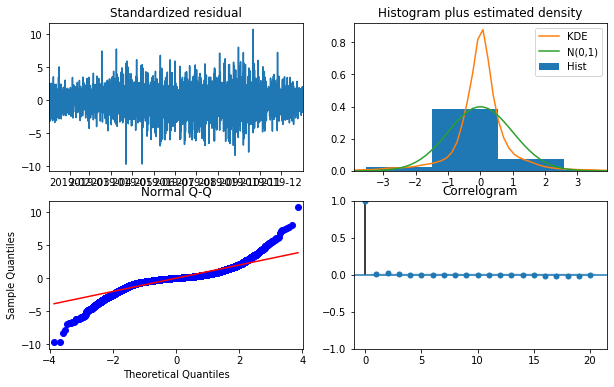

In [70]:
fig = plt.figure(figsize=(10,6))
fig = res2.plot_diagnostics(fig=fig, lags=20)

#### Model 6 Residuals

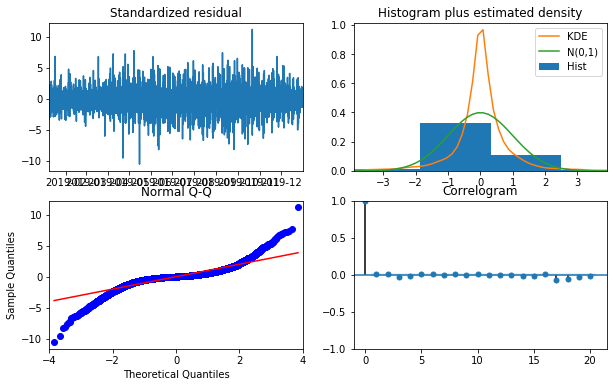

In [71]:
fig = plt.figure(figsize=(10,6))
fig = res6.plot_diagnostics(fig=fig, lags=20)

We still choose Model 6 because of our analysis above and because, based on our reasoning, the lag terms make the most sense.

## Prediction Tool

We created a tool that would allow the user to select a date and time, and get a prediction for that selection using coefficients from Model 6. The data are based on data points from 2019, so input any date from 2019 into the widgets below, and see the model's predicted change in bikes versus the actual change in bikes.

In [77]:
import ipywidgets as widgets

dateSel=widgets.DatePicker(
    description='Pick a date:',
    value=datetime.date(2019,5,5)
)

hourSel=widgets.Dropdown(
    options=[str(i) for i in range(0,24)], #['1', '2', '3'],
    value='17',
    description='Hour:',
    disabled=False,
)

minuteSel=widgets.Dropdown(
    options=['00', '30'],
    value='00',
    description='Minute:',
    disabled=False,
)
    
display(dateSel, hourSel, minuteSel)

DatePicker(value=datetime.date(2019, 5, 5), description='Pick a date:')

Dropdown(description='Hour:', index=17, options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',…

Dropdown(description='Minute:', options=('00', '30'), value='00')

In [78]:
filtered_series = filtered_df.loc[:,"net_change"]
filtered_series

start_time
2019-01-01 09:00:00    1.0
2019-01-01 09:30:00    0.0
2019-01-01 10:00:00   -1.0
2019-01-01 10:30:00    0.0
2019-01-01 11:00:00    0.0
                      ... 
2019-12-31 21:00:00    0.0
2019-12-31 21:30:00   -4.0
2019-12-31 22:00:00    0.0
2019-12-31 22:30:00    0.0
2019-12-31 23:00:00    1.0
Freq: 30T, Name: net_change, Length: 17501, dtype: float64

In [79]:
L1=filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))-datetime.timedelta(hours=1/2)]
L15=filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))-datetime.timedelta(hours=15/2)]
L16=filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))-datetime.timedelta(hours=16/2)]
L48=filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))-datetime.timedelta(hours=48/2)]
L336=filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))-datetime.timedelta(hours=336/2)]

lags=np.array((L1,L15,L16,L48,L336))
lag_coeff=np.array(res6.params[48:53])

In [80]:
dummy=res6.params[0:48]

In [84]:
if int(minuteSel.value) == 30:
    binary_index=(int(hourSel.value)-9)*2 + 1
else:
    binary_index=(int(hourSel.value)-9)*2

binary_hours=np.zeros(48)
binary_hours[int(binary_index)]=1

Using Model 6, our prediction for net change in bikes for the date and time selected above is:

In [82]:
formula = dummy @ binary_hours + lags @ lag_coeff
formula
# removed the constant term from formula because it is part of the dummy variable 

-0.6327213871394114

Here is the actual net change for the date and time selected above:

In [83]:
actual = filtered_series[datetime.datetime(dateSel.value.year, dateSel.value.month, dateSel.value.day, hour=int(hourSel.value), minute=int(minuteSel.value))]
actual

1.0